1. **Importing libraries:**
   - `cv2` library is imported from OpenCV, which is used for image and video processing.
   - `numpy` library is imported as `np`, providing support for working with arrays and matrices.
   - `matplotlib.pyplot` library is imported as `plt`, allowing data visualization and plotting.

2. **Image processing and analysis:**
   - The code utilizes the imported libraries for image processing tasks, such as reading, manipulating, and analyzing images.
   - The `cv2` library provides functions for image loading and processing, while `numpy` is used for efficient array operations.
   - The `matplotlib.pyplot` library allows plotting and visualizing the processed images.


3. **Mathematical computations:**
   - The `math` module provides mathematical functions and constants that can be used in the code.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

The `reorder` function takes a polygon represented as a NumPy array `poly` and reorders its vertices in a specific order based on certain conditions.

1. **Finding the lowest vertex:**
   - The function uses `np.argmax` to find the index of the vertex with the highest y-coordinate (`poly[:, 1]` represents the y-coordinates of all vertices).
   - The index of the lowest vertex is stored in `p_lowest`.

2. **Checking if two vertices have the same y-coordinate:**
   - The function checks if there are two vertices with the same y-coordinate by using `np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2`.
   - If there are two vertices with the same y-coordinate, the function proceeds to reorder the vertices accordingly.
   - If not, the function proceeds to check the angle of the line connecting the lowest vertex with its adjacent vertices.

3. **Reordering vertices based on angle:**
   - If the angle of the line connecting the lowest vertex with its right adjacent vertex is less than or equal to 0, it prints the angle along with the coordinates of the lowest vertex and its right adjacent vertex.
   - If the angle, converted to degrees, is greater than 45 degrees (`angle/np.pi * 180 > 45`), the function reorders the vertices as follows:
     - The lowest vertex becomes the second vertex.
     - The vertex to the left of the lowest vertex becomes the first vertex.
     - The vertex opposite to the lowest vertex becomes the fourth vertex.
     - The vertex to the right of the lowest vertex becomes the third vertex.
   - If the angle is less than or equal to 45 degrees, the function reorders the vertices as follows:
     - The lowest vertex becomes the fourth vertex.
     - The vertex to the right of the lowest vertex becomes the first vertex.
     - The vertex opposite to the lowest vertex becomes the second vertex.
     - The vertex to the left of the lowest vertex becomes the third vertex.

4. **Returning the reordered polygon:**
   - The function returns the reordered polygon as a new NumPy array using advanced indexing (`poly[[p1_index,p0_index, p3_index,p2_index]]`).
   - The vertices are reordered in a counterclockwise manner.

The `reorder` function is used to reorder the vertices of a polygon based on specific conditions, ensuring a consistent vertex order for further processing or analysis.


In [2]:
def reorder(poly):
    # Find the index of the point with the lowest y-coordinate
    p_lowest = np.argmax(poly[:, 1])

    # Check if there are two points with the same lowest y-coordinate
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # Find the index of the point with the lowest sum of x and y coordinates
        p0_index = np.argmin(np.sum(poly, axis=1))

        # Determine the indices of the other points in clockwise order
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4

        # Reorder the points and return the new polygon
        return poly[[p1_index, p0_index, p3_index, p2_index]]
    else:
        # Find the indices of the points to the right and left of the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4

        # Calculate the angle between the lowest point and the point to the right
        angle = np.arctan2(poly[p_lowest_right][1] - poly[p_lowest][1], poly[p_lowest_right][0] - poly[p_lowest][0])

        # Check if the angle is negative
        if angle < 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])

        # Check if the angle is greater than 45 degrees (pi/4 radians)
        if np.degrees(angle) > 45:
            # Determine the indices of the points in counterclockwise order
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p1_index, p0_index, p3_index, p2_index]]
        else:
            # Determine the indices of the points in counterclockwise order
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p1_index, p0_index, p3_index, p2_index]]


The `Reflect101` function takes an input image `img` and a filter size `filter_size` as input parameters. It performs a reflective padding (Reflect101) on the image using a specified filter size and returns the padded image.

1. **Reflective padding:**
   - The function uses the `np.pad` function to pad the input image `img` with reflective boundaries.
   - The `pad_width` parameter is set to `((filter_size//2, filter_size//2), (filter_size//2, filter_size//2))` to specify the amount of padding on each side of the image.
   - The `filter_size//2` is used to ensure that the padding is symmetric around the image.
   - The `mode='reflect'` parameter specifies that the padding should be done using reflective boundaries.
   - The `reflect_type='odd'` parameter ensures that the reflection occurs along odd values rather than even values.

2. **Returning the padded image:**
   - The function returns the padded image as a new NumPy array.

The `Reflect101` function is used to perform reflective padding on an image, which extends the boundaries of the image by reflecting its pixels to provide a smooth continuation of the image content near the boundaries. This is often useful as a preprocessing step in various image processing tasks.


In [3]:
def Reflect101(img,filter_size):
    image = np.pad(img, pad_width=((filter_size//2, filter_size//2), (filter_size//2, filter_size//2)), mode='reflect', reflect_type='odd')
    return image

The `Averaging_Blurring` function performs averaging blurring on an input image `img` using a specified filter size `filter_size`. It does not use any external libraries.

1. **Reflective padding:**
   - The function calls the `Reflect101` function to apply reflective padding to the input image `img` using the specified `filter_size`. The padded image is stored in the `image` variable.

2. **Initializing variables:**
   - The function initializes an array `result` of the same shape as the input image `img` to store the blurred image.

3. **Averaging blurring:**
   - The function applies averaging blurring to each pixel in the image by convolving a filter with the local neighborhood around each pixel.
   - It uses nested loops to iterate over each pixel position in the image.
   - For each pixel at position `(i, j)`, it extracts the corresponding local neighborhood from the padded image `image` using slicing: `image[i : i + filter_size, j : j + filter_size]`.
   - It flattens the local neighborhood and the filter and uses `np.convolve` to perform convolution between the flattened neighborhood and the flattened filter.
   - The resulting convolution output is assigned to the corresponding pixel position `(i, j)` in the `result` array.

4. **Returning the blurred image:**
   - The function returns the computed averaging blurred image as a new NumPy array `result`.

The `Averaging_Blurring` function applies averaging blurring to an image by convolving a filter over each pixel's local neighborhood. Averaging blurring is a common technique used to reduce image noise and smooth out details in an image.


In [4]:
def Averaging_Blurring(img, filter_size):
    image = Reflect101(img, filter_size)
    result = np.zeros((img.shape))
    avg_filter = np.ones((filter_size , filter_size))/ (filter_size * filter_size)
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        result[i,j] = np.convolve(image[i :i + filter_size , j : j + filter_size].flatten(), avg_filter.flatten() , mode='valid')

    return result

The `calculate_distance` function calculates the Euclidean distance between two points, `point1` and `point2`.

1. **Extracting coordinates:**
   - The function unpacks the x and y coordinates of `point1` and `point2` into variables `x1`, `y1`, `x2`, and `y2`.

2. **Calculating distance:**
   - The function uses the formula for Euclidean distance between two points in a two-dimensional space:
     `distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)`.
   - The `math.sqrt` function is used to calculate the square root.

3. **Returning the distance:**
   - The function returns the calculated distance.

The `calculate_distance` function is a utility function that can be used to calculate the Euclidean distance between two points. Euclidean distance is a measure of the straight-line distance between two points in a two-dimensional space.


In [5]:

def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

## Function: scan

The `scan` function performs a series of image processing operations to detect and extract a rectangular region of interest (ROI) from an input image.

1. **Converting to grayscale and applying blurring:**
   - The input image `img` is converted to grayscale.
   - A Gaussian blur is applied to the grayscale image to remove noise.

2. **Edge detection and dilation:**
   - The Canny edge detection algorithm is applied to the blurred image to detect edges.
   - Dilation is performed on the edges image to enhance the edge regions.

3. **Contour extraction and approximation:**
   - Contours are extracted from the dilated image using `cv2.findContours`.
   - The contour with the largest area is selected as the card contour.
   - The contour is approximated using the Ramer-Douglas-Peucker algorithm to reduce the number of vertices.

4. **Rectangle detection and transformation:**
   - If the approximated contour has four vertices, it is considered a rectangle.
   - If not, the convex hull of the contour is used instead.
   - The contour or convex hull vertices are reordered to ensure a consistent vertex order.
   - The four reordered vertices are used to define the source (`pts1`) and destination (`pts2`) points for perspective transformation.

5. **Perspective transformation and output:**
   - The perspective transformation matrix is calculated using `cv2.getPerspectiveTransform` with `pts1` and `pts2`.
   - The input image is copied, and the perspective transformation is applied using `cv2.warpPerspective`.
   - The resulting transformed image (`dst`) is displayed using `plt.imshow` and saved as "output.jpg" using `cv2.imwrite`.

The `scan` function combines various image processing techniques to detect and extract a rectangular region of interest from an input image.


In [6]:

def scan(img , kernel_size ,t_lower , t_higher , output_name):
  rectangle = False
  flag_super_no_rectangle = False
  # converting to grayscale
  gray_im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # apply gaussian blur to remove noise
  blurred_im = cv2.GaussianBlur(gray_im, kernel_size, 0)
  blurred_im = Averaging_Blurring(gray_im , kernel_size[0])
  if blurred_im.dtype != np.uint8:
    blurred_im = blurred_im.astype(np.uint8)
  edges_im_blurred = cv2.Canny(blurred_im, t_lower, t_higher)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  dilated_im = cv2.dilate(edges_im_blurred, kernel, iterations=2)

  contours, hierarchy = cv2.findContours(dilated_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  card_contour = max(contours, key=cv2.contourArea)
  # peri = cv2.arcLength(card_contour, True)
  # card_contour = cv2.approxPolyDP(card_contour, 0.03 * peri, True)
  img_copy = img.copy()
  cv2.drawContours(img_copy, [card_contour], -1, (0, 0, 255), 2)
  hull = cv2.convexHull(card_contour)
  epsilon = 0.05 * cv2.arcLength(card_contour, True)
  approx = cv2.approxPolyDP(card_contour, epsilon, True)
  if len(approx) != 4:
    epsilon = 0.01 * cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    if len(approx) != 4:
      rect = cv2.minAreaRect(card_contour)
      box = cv2.boxPoints(rect)
      box = reorder(box)
      # flag_super_no_rectangle = True
      # x, y, w, h = cv2.boundingRect(card_contour)
    else:
      box = reorder(approx.reshape(4, 2)).astype(np.float32)

  else:
    rectangle = True
    box = reorder(approx.reshape(4, 2)).astype(np.float32)

  if flag_super_no_rectangle == True :
    # converting old vertices to new vertices
    pts1 = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
  else:
    pts1 = np.float32(box)
  # Reshape the points to a 3D array
  points = pts1.reshape((-1, 1, 2))
  points = np.int0(points)
  # # Draw the rectangle on the image
  cv2.polylines(img_copy, [points], isClosed=True, color=(0, 255, 0), thickness=2)
  plt.imshow(img_copy , cmap = 'gray')
  if flag_super_no_rectangle == False and calculate_distance(box[0], box[1]) < calculate_distance(box[0], box[3])  :
    pts2 = np.float32([[860, 0], [860 , 540], [0, 540] , [0, 0]])
  else :
    pts2 = np.float32([[0, 0], [860 , 0], [860, 540] , [0, 540]])


  if rectangle == False and flag_super_no_rectangle == False:
      if calculate_distance(box[0], box[1]) < calculate_distance(box[0], box[3]) :
        pts2 = np.float32([[0, 0], [0 , 540], [860, 540] , [860, 0]])
      else :
        pts2 = np.float32([[860, 0], [0 , 0], [0, 540] , [860, 540]])
  if flag_super_no_rectangle == True :
    pts2 = np.float32([[0, 0], [860 , 0], [860, 540] , [0, 540]])
  M = cv2.getPerspectiveTransform(pts1, pts2)
  img_copy = img.copy()
  dst = cv2.warpPerspective(img_copy, M, (860, 540))
  plt.imshow(dst , cmap = 'gray')
  cv2.imwrite("output.jpg", dst)

## Thresholding of Grayscale Image

The code you provided performs thresholding on a grayscale image read from "output.jpg" using OpenCV. Here's a breakdown of the code:


In [7]:
# img7 = cv2.imread('2.jpg')
# # img7 = cv2.imread('3.jpg')
# # img7 = cv2.imread('5.jpg')

# scan(img7 , (9,9) , 0 , 50 , 'img7_out.jpg')

# image = cv2.imread("output.jpg", 0)
# _, thresholded_image_next = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# # thresholded_image_next = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 12)
# img_copy = thresholded_image_next.copy()
# modified_image = cv2.resize(img_copy, (1500, 1000))
# plt.imshow(modified_image, cmap='gray')

The make_templates function generates a list of candidate templates by performing various transformations on the input template image. Here's a step-by-step breakdown of the code:

Initialize an empty list to store the candidate templates: list_candid_temps = [].

Define the desired number of resize steps. In this case, resize_steps is set to 10.

Calculate the resize ratios for both width and height using NumPy's linspace function. The linspace function generates an array of evenly spaced values between the specified start and end points. Here, the width ratios range from 1 to 0.4, and the height ratios range from 1 to 0.4.

Iterate over the resize ratios using nested for loops. For each width and height ratio combination:

a. Check if the absolute difference between the width and height ratios is 0. If they are equal, proceed with further transformations. This condition ensures that only square-like ratios are considered.

b. Resize the template image using OpenCV's resize function. The image is resized based on the current width and height ratios.

c. Perform erosion on the resized template using OpenCV's erode function. Erosion is a morphological operation that erodes away the boundaries of an object in an image.

d. Rotate the resized template and the eroded template. This is done by iterating over a range of angles (-5 to 4) and applying a rotation transformation using OpenCV's warpAffine function.

e. Add the rotated templates (both the original and eroded versions) to the list of candidate templates.

After all iterations, return the list of candidate templates: return list_candid_temps.

This code essentially creates a set of templates by resizing, eroding, and rotating the input template image. The resulting templates can be used for further analysis or processing.

In [8]:
def make_templates(template):
    list_candid_temps = []
    # Define the desired number of resize steps
    resize_steps = 10
    # Calculate the resize ratios for both width and height
    width_ratios = np.linspace(1, 0.4, resize_steps)
    height_ratios = np.linspace(1, 0.4, resize_steps)
    # Iterate over the resize ratios
    for width_ratio in width_ratios:
        for height_ratio in height_ratios:
            if abs(width_ratio - height_ratio) == 0:
                # Resize the template
                resized_template = cv2.resize(template, (int(template.shape[1] * width_ratio), int(template.shape[0] * height_ratio)))
                # erosion
                kernel = np.ones((5,5),np.uint8)
                erosion = cv2.erode(resized_template,kernel,iterations = 1)
                # Rotate the resized template
                for angle in range(-5, 5):
                    rotated_template = cv2.warpAffine(resized_template, cv2.getRotationMatrix2D((resized_template.shape[1] / 2, resized_template.shape[0] / 2), angle, 1), (resized_template.shape[1], resized_template.shape[0]))
                    # Add the rotated template to the list of candidates
                    list_candid_temps.append(rotated_template)
                # Rotate the resized template
                for angle in range(-5, 5):
                    rotated_template = cv2.warpAffine(erosion, cv2.getRotationMatrix2D((erosion.shape[1] / 2, erosion.shape[0] / 2), angle, 1), (erosion.shape[1], erosion.shape[0]))
                    # Add the rotated template to the list of candidates
                    list_candid_temps.append(rotated_template)

    return list_candid_temps

## `extract_segments` Function

The `extract_segments` function takes an input `image` and performs the following steps to extract segments (rectangular regions) from the image:

1. Threshold the image using OpenCV's `threshold` function. This operation converts the image into a binary image where pixels are either black or white based on a threshold value. The thresholding method used is `cv2.THRESH_BINARY + cv2.THRESH_OTSU`, which automatically determines the threshold value based on Otsu's method.

2. Find contours in the thresholded image using OpenCV's `findContours` function. Contours represent the boundaries of objects in an image.

3. Find the contour with the largest area among all the contours using the `max` function with the `cv2.contourArea` as the key. This contour corresponds to the largest object in the image.

4. Create a new image (`matched_image`) by converting the input `image` from grayscale to color using OpenCV's `cvtColor` function.

5. Iterate over all contours, excluding the largest contour. For each contour:

   - Determine the bounding rectangle coordinates and dimensions using the `cv2.boundingRect` function.
   - Store the rectangle coordinates and dimensions in the `rectangles` list.

6. Remove nested rectangles from the `rectangles` list. This step ensures that only the outermost rectangles are kept, eliminating any smaller rectangles contained within larger ones.

7. Filter out rectangles that are too small. Rectangles with width and height less than 20 pixels are removed from the `rectangles` list.

8. Filter out rectangles that are too large. Rectangles with width and height greater than 100 pixels are removed from the `rectangles` list.

9. Filter out rectangles where the width is greater than the height. This step removes rectangles that are horizontally oriented.

10. Cluster the remaining rectangles that are close to each other based on their y-coordinates. Rectangles within a certain y-coordinate threshold (30 pixels in this case) are grouped together into clusters. The clusters are stored in the `clustered_rectangles` list.

11. Sort each cluster of rectangles by their x-coordinates.

12. Save the top 16 rectangles with the largest area in each cluster. The rectangles in each cluster are sorted based on their area, and the top 16 rectangles are selected.

13. Draw green rectangles on the `matched_image` for each rectangle in the `clustered_rectangles` list using OpenCV's `rectangle` function.

14. Display the `matched_image` using Matplotlib's `imshow` and `show` functions.

15. Return the `clustered_rectangles` list and the `matched_image`.

## `fa_extract_segments` Function

The `fa_extract_segments` function is similar to the `extract_segments` function, with a few modifications:

1. The filtering step to remove rectangles with width greater than height is commented out using the `#` symbol. This means that rectangles with any orientation (both horizontal and vertical) are included in the `filtered_rectangles` list.

2. The filtering step to remove rectangles that are too small uses a different threshold. Rectangles with width and height less than 5 pixels are removed from the `filtered_rectangles` list.

The remaining steps in the `fa_extract_segments` function are the same as in the `extract_segments` function.

Both functions return the `clustered_rectangles` list (rectangles grouped into clusters) and the `matched_image` with drawn rectangles. The `matched_image` is displayed using Matplotlib.Certainly! Here's an explanation of the `extract_segments` and `fa_extract_segments` functions in markdown format:

## `extract_segments` Function

The `extract_segments` function takes an input `image` and performs the following steps to extract segments (rectangular regions) from the image:

1. Threshold the image using OpenCV's `threshold` function. This operation converts the image into a binary image where pixels are either black or white based on a threshold value. The thresholding method used is `cv2.THRESH_BINARY + cv2.THRESH_OTSU`, which automatically determines the threshold value based on Otsu's method.

2. Find contours in the thresholded image using OpenCV's `findContours` function. Contours represent the boundaries of objects in an image.

3. Find the contour with the largest area among all the contours using the `max` function with the `cv2.contourArea` as the key. This contour corresponds to the largest object in the image.

4. Create a new image (`matched_image`) by converting the input `image` from grayscale to color using OpenCV's `cvtColor` function.

5. Iterate over all contours, excluding the largest contour. For each contour:

   - Determine the bounding rectangle coordinates and dimensions using the `cv2.boundingRect` function.
   - Store the rectangle coordinates and dimensions in the `rectangles` list.

6. Remove nested rectangles from the `rectangles` list. This step ensures that only the outermost rectangles are kept, eliminating any smaller rectangles contained within larger ones.

7. Filter out rectangles that are too small. Rectangles with width and height less than 20 pixels are removed from the `rectangles` list.

8. Filter out rectangles that are too large. Rectangles with width and height greater than 100 pixels are removed from the `rectangles` list.

9. Filter out rectangles where the width is greater than the height. This step removes rectangles that are horizontally oriented.

10. Cluster the remaining rectangles that are close to each other based on their y-coordinates. Rectangles within a certain y-coordinate threshold (30 pixels in this case) are grouped together into clusters. The clusters are stored in the `clustered_rectangles` list.

11. Sort each cluster of rectangles by their x-coordinates.

12. Save the top 16 rectangles with the largest area in each cluster. The rectangles in each cluster are sorted based on their area, and the top 16 rectangles are selected.

13. Draw green rectangles on the `matched_image` for each rectangle in the `clustered_rectangles` list using OpenCV's `rectangle` function.

14. Display the `matched_image` using Matplotlib's `imshow` and `show` functions.

15. Return the `clustered_rectangles` list and the `matched_image`.

## `fa_extract_segments` Function

The `fa_extract_segments` function is similar to the `extract_segments` function, with a few modifications:

1. The filtering step to remove rectangles with width greater than height is commented out using the `#` symbol. This means that rectangles with any orientation (both horizontal and vertical) are included in the `filtered_rectangles` list.

2. The filtering step to remove rectangles that are too small uses a different threshold. Rectangles with width and height less than 5 pixels are removed from the `filtered_rectangles` list.

The remaining steps in the `fa_extract_segments` function are the same as in the `extract_segments` function.

Both functions return the `clustered_rectangles` list (rectangles grouped into clusters) and the `matched_image` with drawn rectangles. The `matched_image` is displayed using Matplotlib.

In [9]:
def extract_segments(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    matched_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    rectangles = []
    for contour in contours:
        if contour is not largest_contour:
            x, y, w, h = cv2.boundingRect(contour)
            rectangles.append((x, y, w, h))

    # Remove nested rectangles
    filtered_rectangles = []
    for i in range(len(rectangles)):
        include_rect = True
        for j in range(len(rectangles)):
            if i != j:
                x1, y1, w1, h1 = rectangles[i]
                x2, y2, w2, h2 = rectangles[j]
                if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                    include_rect = False
                    break
        if include_rect:
            filtered_rectangles.append(rectangles[i])

    # remove rectangles that are too small
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] > 20 and rect[3] > 20]

    # remove rectangles that are too large
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < 100 and rect[3] < 100]

    # remove rectangles that width is greater than height
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < rect[3]]

    # cluster rectangles that are close to each other into groups based on their y
    # first, sort rectangles by x and y
    filtered_rectangles.sort(key=lambda x: x[0])
    filtered_rectangles.sort(key=lambda x: x[1])

    clustered_rectangles = []
    for rect in filtered_rectangles:
        if len(clustered_rectangles) == 0:
            clustered_rectangles.append([rect])
        else:
            last_cluster = clustered_rectangles[-1]
            last_rect = last_cluster[-1]
            if abs(rect[1] - last_rect[1]) < 30:
                last_cluster.append(rect)
            else:
                clustered_rectangles.append([rect])


    # sort each cluster by x
    for cluster in clustered_rectangles:
        cluster.sort(key=lambda x: x[0])

    # save top 16 rectangles that have the largest area in each cluster
    filtered_rectangles = []
    for cluster in clustered_rectangles:
        cluster = sorted(cluster, key=lambda x: x[2] * x[3], reverse=True)
        # if len(cluster) > 16:
        #     cluster = cluster[:16]
        filtered_rectangles += cluster


    # Draw the filtered rectangles
    for cluster in clustered_rectangles:
        for (x, y, w, h) in cluster:
            cv2.rectangle(matched_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Display the image
    plt.figure(figsize=(20, 20))
    plt.imshow(matched_image)
    plt.show()
    
    return clustered_rectangles, matched_image
    





def fa_extract_segments(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    matched_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    rectangles = []
    for contour in contours:
        if contour is not largest_contour:
            x, y, w, h = cv2.boundingRect(contour)
            rectangles.append((x, y, w, h))

    # Remove nested rectangles
    filtered_rectangles = []
    for i in range(len(rectangles)):
        include_rect = True
        for j in range(len(rectangles)):
            if i != j:
                x1, y1, w1, h1 = rectangles[i]
                x2, y2, w2, h2 = rectangles[j]
                if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                    include_rect = False
                    break
        if include_rect:
            filtered_rectangles.append(rectangles[i])

    # remove rectangles that are too small
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] > 5 and rect[3] > 5]

    # remove rectangles that are too large
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < 100 and rect[3] < 100]

    # remove rectangles that width is greater than height
    # filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < rect[3]]

    # cluster rectangles that are close to each other into groups based on their y
    # first, sort rectangles by x and y
    filtered_rectangles.sort(key=lambda x: x[0])
    filtered_rectangles.sort(key=lambda x: x[1])

    clustered_rectangles = []
    for rect in filtered_rectangles:
        if len(clustered_rectangles) == 0:
            clustered_rectangles.append([rect])
        else:
            last_cluster = clustered_rectangles[-1]
            last_rect = last_cluster[-1]
            if abs(rect[1] - last_rect[1]) < 30:
                last_cluster.append(rect)
            else:
                clustered_rectangles.append([rect])


    # sort each cluster by x
    for cluster in clustered_rectangles:
        cluster.sort(key=lambda x: x[0])

    # save top 16 rectangles that have the largest area in each cluster
    filtered_rectangles = []
    for cluster in clustered_rectangles:
        cluster = sorted(cluster, key=lambda x: x[2] * x[3], reverse=True)
        # if len(cluster) > 16:
        #     cluster = cluster[:16]
        filtered_rectangles += cluster


    # Draw the filtered rectangles
    for cluster in clustered_rectangles:
        for (x, y, w, h) in cluster:
            cv2.rectangle(matched_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Display the image
    plt.figure(figsize=(20, 20))
    plt.imshow(matched_image)
    plt.show()
    
    return clustered_rectangles, matched_image
    







The code snippet provided performs OCR (Optical Character Recognition) on an image to extract information from either a bank card or a national card. Here's a breakdown of the code:

1. The function `is_national_card` takes an input `image` and checks whether it is a national card or a bank card. It does this by performing template matching on a specific region of the image using a template image of the word "Allah" (`sun.png`). If the template matching result exceeds a threshold value (0.3), it is considered a national card. Otherwise, it is assumed to be a bank card.

2. If the image is determined to be a national card, the `generate_templates` function is called with the dataset name `'Fa_dataset'`. This function reads multiple templates (`0.png`, `1.png`, ..., `slash.png`) from the dataset and generates a dictionary of candidate templates for each template. The generated templates are used for template matching later.

3. If the image is a national card, a region of interest (ROI) is selected from the image using array slicing (`image[200:650, 800:1250]`). This ROI is where the card information is located.

4. The `fa_extract_segments` function is called with the ROI image. This function extracts segments (rectangular regions) from the image using image processing techniques such as thresholding, contour finding, and clustering. It returns the clustered rectangles and an image with rectangles drawn around the segments.

5. For each cluster of rectangles, the `template_matching` function is called with the cluster and the generated templates. This function compares the cropped rectangle images with the candidate templates using template matching. It assigns a score to each template based on the similarity with the cropped image. The template with the highest score is selected as the recognized character or symbol.

6. Based on the recognized characters or symbols, the extracted information is printed. If a slash character ('/') is present, it is assumed to be an expiration date, and the characters around the slash are extracted as the expiration date. If the length of the extracted phrase is exactly 10, it is considered a national ID.

7. If the image is determined to be a bank card (not a national card), the `generate_templates` function is called with the dataset name `'dataset'` instead.

8. The `extract_segments` function is called with the original image. This function extracts segments from the image using similar image processing techniques as in `fa_extract_segments`.

9. The `template_matching` function is called for each cluster of rectangles, similar to the previous case. The extracted information is printed based on the recognized characters or symbols. If a slash character is present, it is assumed to be an expiration date, and the characters around the slash are extracted as the expiration date. If the length of the extracted phrase is exactly 16, it is considered a card number.

Overall, the code performs template matching on cropped regions of the input image to recognize characters and symbols. It then uses the recognized information to determine the type of card (national or bank) and extract relevant information accordingly.

In [10]:
def template_matching(image, matched_image, filtered_rectangles, templates):
    # crop rectangles and compare with candidates
    scores = {(x, y, w, h): {template: 0 for template in templates} for (x, y, w, h) in filtered_rectangles}
    for (x, y, w, h) in filtered_rectangles:
        crop_img = image[y:y+h, x:x+w]
        for template in templates:
            max_score = 0
            for candid_template in templates[template]:
                # make size equal
                candid_template = cv2.resize(candid_template, (crop_img.shape[1], crop_img.shape[0]))
                # compare in CCOEFF_NORMED
                res = cv2.matchTemplate(crop_img, candid_template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                if max_val > max_score:
                    max_score = max_val
            scores[(x, y, w, h)][template] = max_score

    # find max score
    max_scores = {}
    for (x, y, w, h) in filtered_rectangles:
        # set key of max_scores
        number = -1
        max_score = 0
        for template in templates:
            if scores[(x, y, w, h)][template] > max_score:
                max_score = scores[(x, y, w, h)][template]
                number = template
        max_scores[(x, y, w, h)] = number if max_score > 0.1 else None

    # sort by x
    filtered_rectangles = sorted(filtered_rectangles, key=lambda x: x[0])

    data = ""
    # draw number
    for (x, y, w, h) in filtered_rectangles:
        char = max_scores.get((x, y, w, h))
        if char is None:
            continue
        cv2.putText(matched_image, max_scores[(x, y, w, h)], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        if char == 'slash.png':
            char = '/.png'
        data += char.split('.')[0]

    return data

In [11]:
def generate_templates(dataset_name):
    templates_img = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', 'slash.png']
    # make_candidates
    templates = {template: [] for template in templates_img}
    for template in templates_img:
        i = 1
        while True:
            try:
                imread_template = cv2.imread('./'+ dataset_name + '_' + str(i) + "/" + template, 0)
                templates[template] += make_templates(imread_template)
            except:
                break
            i += 1

    return templates

In [12]:
# check if card is bank-card or national-card
def is_national_card(image):
    allah = image[700:1000 , 0:300]
    allah_template = cv2.imread('sun.png', 0)
    # template matching
    res = cv2.matchTemplate(allah, allah_template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.5
    # show hit map
    loc = np.where(res >= threshold)
    # print max score
    # print(np.max(res))
    if len(loc[0]) > 0:
        return True
    else:
        return False

-2.478337914441314 [666 498] [291 205]


C:\Users\free\AppData\Local\Temp\ipykernel_190456\1693538939.py:47: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)


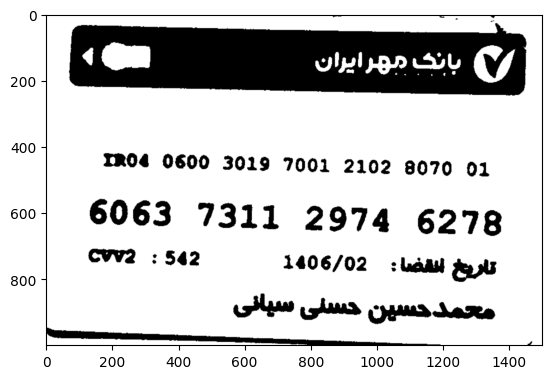

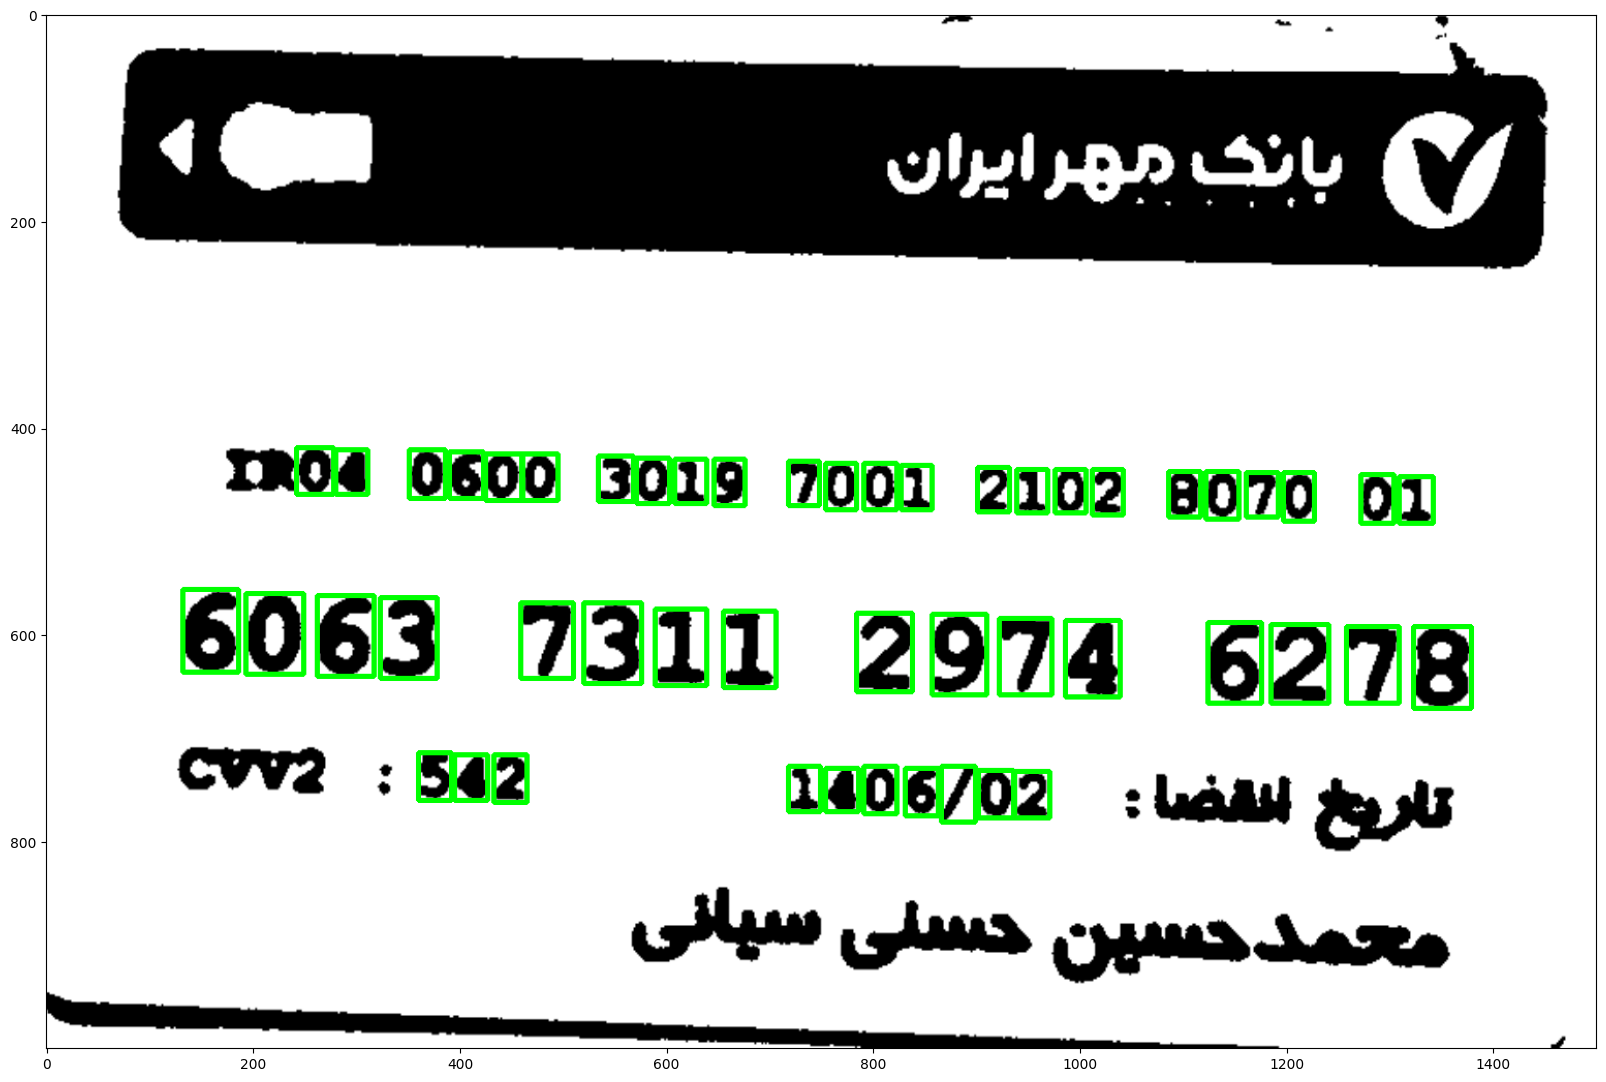

card_number:  6063731129746278
expir_date:  06/02


In [13]:
img7 = cv2.imread('2.jpg')
# img7 = cv2.imread('3.jpg')
# img7 = cv2.imread('5.jpg')

scan(img7 , (9,9) , 0 , 50 , 'img7_out.jpg')

image = cv2.imread("output.jpg", 0)
_, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresholded_image_next = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 12)
img_copy = image.copy()
image = cv2.resize(img_copy, (1500, 1000))
plt.imshow(image, cmap='gray')
        
    
if is_national_card(image):
    templates = generate_templates('Fa_dataset')
    image = image[200:650, 800:1250]
    clustered_rectangles, matched_image = fa_extract_segments(image)
    
    for cluster in clustered_rectangles:
        phrase = template_matching(image, matched_image, cluster, templates)
        if "/" in phrase:
            print("expir_date: ", phrase)
            continue
        elif len(phrase) == 10:
            national_id = phrase
            print("national_id: ", national_id)
    
else:
    templates = generate_templates('dataset')
    clustered_rectangles, matched_image = extract_segments(image)

    for cluster in clustered_rectangles:
        phrase = template_matching(image, matched_image, cluster, templates)
        if "/" in phrase:
            slash_index = phrase.index("/")
            expir_date = phrase[slash_index - 2: slash_index + 3]
            if len(phrase)>=7 and slash_index >= 4:
                print("expir_date: ", expir_date)
        elif len(phrase) == 16:
            card_number = phrase
            print("card_number: ", card_number)

